In [1]:
# read in wrf auxout & lasso files
# compare large scale forcing

# perform area average on wrf 3-km outputs
# in order to match lasso 16-km outputs

# time-height plots

import numpy as np
import pandas as pd
import wrf
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import xarray as xr
import datetime
import math
import seaborn as sns

# c1 site location
site_latitude  = 36.6050
site_longitude = -97.485

# horizontal resolutions of 2 datasets, in km
wrf_hres = 3
lasso_hres = 16

# interpolate wrf variables to this height
# also a specified height in lasso data
target_height_agl = 80

# number of wrf cells in 1 lasso cell, in 1 direction 
# wrf cell span includes the cell of target location
wrf_cell_span = np.floor(lasso_hres/wrf_hres)

# convert an even number to an odd number, round down
# so the total wrf cell span is smaller than a lasso cell horizontal resolution
if (wrf_cell_span % 2) == 0:
    wrf_cell_span -= 1

# wrf cell to account for in each direction
wrf_ij_diff = (wrf_cell_span-1)/2

In [2]:
wrf_path = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805m/auxout/target/'

file_list = glob.glob(wrf_path+'mmc_d02*')

for ind, file in enumerate(file_list):

    wrf_single = Dataset(file,'r')

    site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)
    area_start_ind = site_loc_ij.values-wrf_ij_diff
    area_end_ind = site_loc_ij.values+wrf_ij_diff

    wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)
    # height should not change over time in wrf
    z_agl  = wrf.getvar(wrf_single, 'height_agl')

    ru_tend = wrf.getvar(wrf_single, 'RU_TEND_PGF', timeidx=wrf.ALL_TIMES)
    muu = wrf.getvar(wrf_single, 'MUU', timeidx=wrf.ALL_TIMES)
    # to match lasso data
    u_tend = ru_tend/muu
    
    rv_tend = wrf.getvar(wrf_single, 'RV_TEND_PGF', timeidx=wrf.ALL_TIMES)
    muv = wrf.getvar(wrf_single, 'MUV', timeidx=wrf.ALL_TIMES)
    v_tend = rv_tend/muv
    
    t_tend = wrf.getvar(wrf_single, 'T_TEND_ADV', timeidx=wrf.ALL_TIMES)
    mut = wrf.getvar(wrf_single, 'MUT', timeidx=wrf.ALL_TIMES)
    t_tend = t_tend/mut

    hgt = z_agl[:, site_loc_ij.values[1], site_loc_ij.values[0]]
    
    # j first, i second
    u_slice = u_tend.isel(south_north=slice(int(area_start_ind[1]), int(area_end_ind[1]+1)), 
                          west_east_stag=slice(int(area_start_ind[0]), int(area_end_ind[0]+1)))
    u_mean = u_slice.mean(dim=['south_north', 'west_east_stag'])
    
    v_slice = v_tend.isel(south_north_stag=slice(int(area_start_ind[1]), int(area_end_ind[1]+1)), 
                          west_east=slice(int(area_start_ind[0]), int(area_end_ind[0]+1)))
    v_mean = v_slice.mean(dim=['south_north_stag', 'west_east'])
    
    t_slice = t_tend.isel(south_north=slice(int(area_start_ind[1]), int(area_end_ind[1]+1)), 
                          west_east=slice(int(area_start_ind[0]), int(area_end_ind[0]+1)))
    t_mean = t_slice.mean(dim=['south_north', 'west_east'])
    
    ds = u_mean.to_dataset(name='U_PGF tendency [m s-2]')
    ds['V_PGF tendency [m s-2]'] = v_mean
    ds['Temp advection [K s-1]'] = t_mean
    
    if ind == 0: 
        ds_all = ds
    else: 
        ds_all = xr.concat([ds, ds_all], dim='Time')
        
    # assign height coordinates to the last iteration
    if ind == len(file_list)-1:
        ds_all = ds_all.assign_coords({'Height': ('bottom_top', hgt)})
        
ds_all = ds_all.sortby('Time')

wrf_ds_below2km = ds_all.where(ds_all['Height'] < 2000, drop=True)

In [37]:
lasso_sounding = '/projects/mmcpnnl/jlee/lasso/0805/0805-3/config/input_sounding'

lasso_input_sounding_col = ['height agl', 'potential temperature', 'vapor mixing ratio', 
                            'u velocity', 'v velocity']

df = pd.read_csv(lasso_sounding, skiprows=1, sep=' ')

new_df = (df.T.reset_index().T.reset_index(drop=True)
            .set_axis([i for i in lasso_input_sounding_col], axis=1))

for col in new_df.columns:
    new_df[col] = pd.to_numeric(new_df[col])

f = 2 * 7.292*1e-5 * math.sin(math.radians(site_latitude))

new_df['u_tend_lasso'] = f*new_df['u velocity']
new_df['v_tend_lasso'] = -f*new_df['v velocity']

lasso_sounding_ds = new_df.to_xarray()
lasso_sounding_ds = lasso_sounding_ds.rename({'index': 'Height'})
lasso_sounding_ds['Height'] = lasso_sounding_ds['height agl']
# refer to WRF ds
lasso_sounding_ds = lasso_sounding_ds.assign_coords({'Time': ds_all.Time})

lasso_sounding_ds['u_tend_lasso [m s-2]'], _ = xr.broadcast(lasso_sounding_ds['u_tend_lasso'], lasso_sounding_ds['Time'])
lasso_sounding_ds['v_tend_lasso [m s-2]'], _ = xr.broadcast(lasso_sounding_ds['v_tend_lasso'], lasso_sounding_ds['Time'])
lasso_sounding_ds_below2km = lasso_sounding_ds.where(lasso_sounding_ds['Height'] < 2000, drop=True)

In [149]:
def plot_timeheight_wrflasso_uvtend(wrf_var, lasso_var, wrf_title, lasso_title): 

    wrf_da, lasso_da = wrf_ds_below2km[wrf_var], lasso_sounding_ds_below2km[lasso_var]
    v_max = np.max([wrf_da.max(), lasso_da.max()])
    v_min = np.min([wrf_da.min(), lasso_da.min()])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
    
    p1 = wrf_da.plot(x='Time', y='Height', vmin=v_min, vmax=v_max, ax=ax1)
    ax1.set_ylabel('Height agl (m)')
    ax1.set_title(wrf_title)
#     cb1 = plt.colorbar(p1, ax=ax1, boundaries=np.linspace(v_min, v_max))
#     cb1.set_label(wrf_var)
    
    p2 = lasso_da.plot(x='Time', y='Height', vmin=v_min, vmax=v_max, ax=ax2)
    ax2.set_ylabel('Height agl (m)')
    ax2.set_title(lasso_title)
#     cb2 = plt.colorbar(p2, ax=ax2, boundaries=np.linspace(v_min, v_max))
#     cb2.set_label(lasso_var)

    plt.tight_layout()
    plt.show()

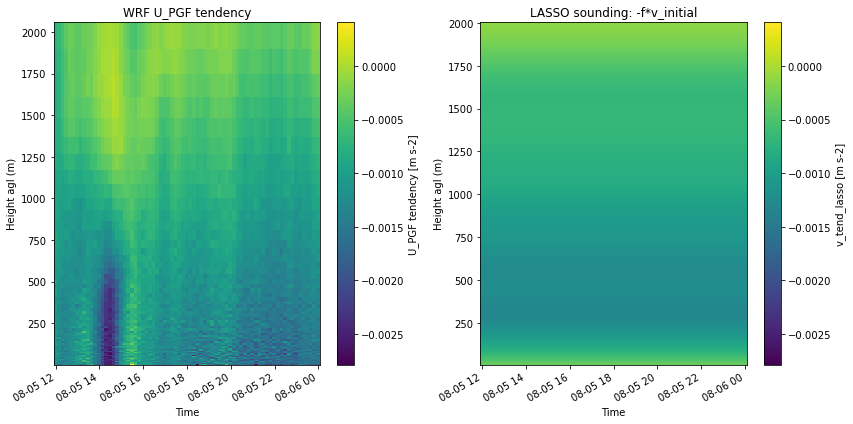

In [150]:
plot_timeheight_wrflasso_uvtend('U_PGF tendency [m s-2]', 'v_tend_lasso [m s-2]', 
                                'WRF U_PGF tendency', 'LASSO sounding: -f*v_initial')

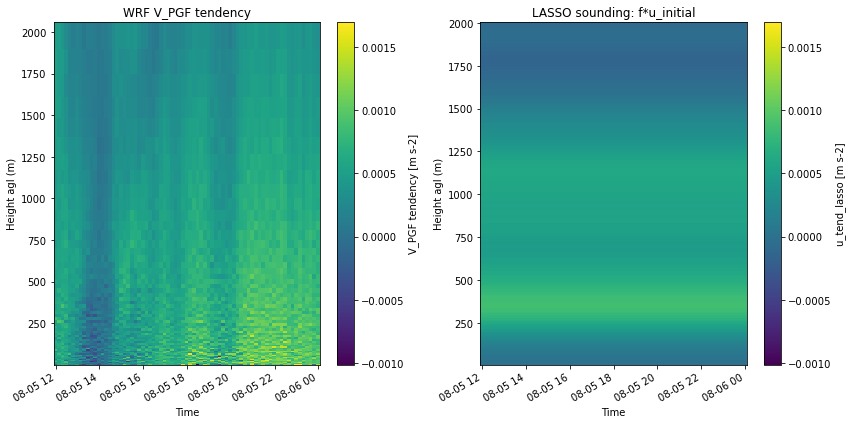

In [151]:
plot_timeheight_wrflasso_uvtend('V_PGF tendency [m s-2]', 'u_tend_lasso [m s-2]', 
                                'WRF V_PGF tendency', 'LASSO sounding: f*u_initial')

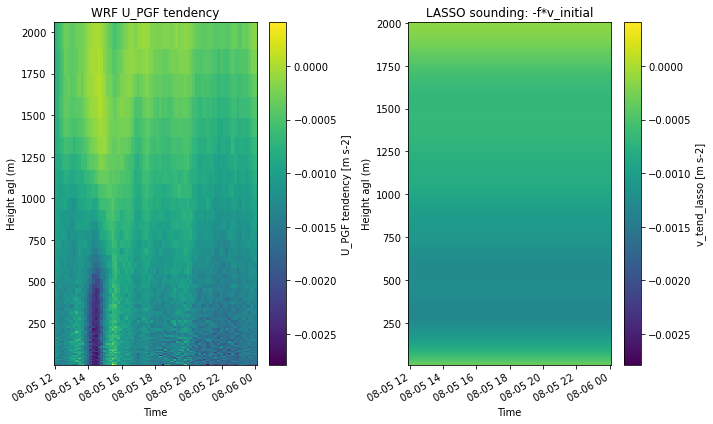

In [46]:
def plot_timeheight_wrflasso_uvtend(wrf_var, lasso_var, wrf_title, lasso_title): 

    wrf_da, lasso_da = wrf_ds_below2km['U_PGF tendency [m s-2]'], lasso_sounding_ds_below2km['v_tend_lasso [m s-2]']
    v_max = np.max([wrf_da.max(), lasso_da.max()])
    v_min = np.min([wrf_da.min(), lasso_da.min()])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))

    wrf_da.plot(x='Time', y='Height', vmin=v_min, vmax=v_max, ax=ax1)
    ax1.set_ylabel('Height agl (m)')
    ax1.set_title('WRF U_PGF tendency')

    lasso_da.plot(x='Time', y='Height', vmin=v_min, vmax=v_max, ax=ax2)
    ax2.set_ylabel('Height agl (m)')
    ax2.set_title('LASSO sounding: -f*v_initial')

    plt.tight_layout()
    plt.show()

In [42]:
wrf_ds_below2km['U_PGF tendency [m s-2]']

<xarray.DataArray 'U_PGF tendency [m s-2]' (Time: 73, bottom_top: 59)>
array([[-0.000978  , -0.00146881, -0.00101598, ..., -0.00081135,
        -0.00078217, -0.00071432],
       [-0.00167048, -0.00128449, -0.00130659, ..., -0.00071858,
        -0.00070871, -0.00066427],
       [-0.00137974, -0.00143236, -0.00117168, ..., -0.00059702,
        -0.00058907, -0.00055002],
       ...,
       [-0.00186868, -0.00151189, -0.00182297, ..., -0.00047554,
        -0.00035516, -0.00027627],
       [-0.00186458, -0.00146909, -0.00147857, ..., -0.00039293,
        -0.00022277, -0.00019096],
       [-0.0019391 , -0.00146752, -0.00148083, ..., -0.00036108,
        -0.00022045, -0.00016183]], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 2018-08-05T12:00:00 ... 2018-08-06
    XTIME    (Time) float32 1.44e+03 1.45e+03 1.46e+03 ... 2.15e+03 2.16e+03
    Height   (bottom_top) float32 2.638 7.872 13.1 ... 1.823e+03 1.98e+03
Dimensions without coordinates: bottom_top

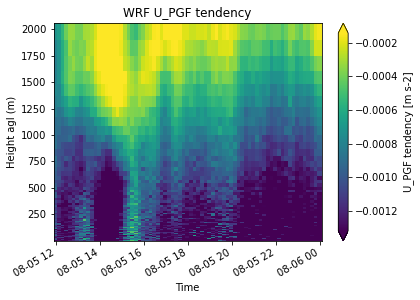

In [24]:


wrf_var.plot(x='Time', y='Height', vmin=v_min, vmax=v_max)

plt.ylabel('Height agl (m)')
plt.title('WRF U_PGF tendency')

plt.show()

In [ ]:
ds_below2km['U_PGF tendency [m s-2]'].plot(x='Time', y='Height', vmin=0)

plt.ylabel('Height agl (m)')
plt.title('WRF U_PGF tendency')

plt.show()

In [212]:
ds_below2km['U_PGF tendency [m s-2]'].max()

<xarray.DataArray 'U_PGF tendency [m s-2]' ()>
array(0.00040708)

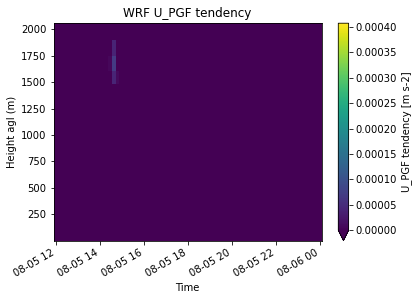

In [9]:
ds_below2km['U_PGF tendency [m s-2]'].plot(x='Time', y='Height', vmin=0)

plt.ylabel('Height agl (m)')
plt.title('WRF U_PGF tendency')

plt.show()

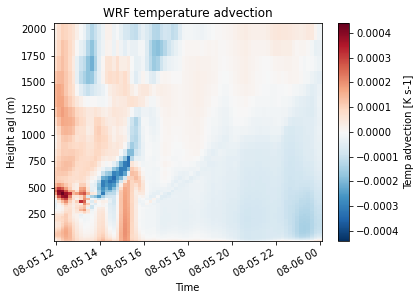

In [7]:
ds_below2km['Temp advection [K s-1]'].plot(x='Time', y='Height')

plt.ylabel('Height agl (m)')
plt.title('WRF temperature advection')

plt.show()

In [39]:
ds_all

<xarray.Dataset>
Dimensions:                 (Time: 73, bottom_top: 87)
Coordinates:
  * Time                    (Time) datetime64[ns] 2018-08-05T12:00:00 ... 201...
    XTIME                   (Time) float32 1.44e+03 1.45e+03 ... 2.16e+03
    Height                  (bottom_top) float32 2.638 7.872 ... 1.605e+04
Dimensions without coordinates: bottom_top
Data variables:
    U_PGF tendency [m s-2]  (Time, bottom_top) float32 -0.000978 ... 5.523e-05
    V_PGF tendency [m s-2]  (Time, bottom_top) float32 5.72e-05 ... -0.0001918
    Temp advection [K s-1]  (Time, bottom_top) float32 1.112e-05 ... 0.0001385

In [44]:
new_ds = new_df.to_xarray()
new_ds = new_ds.assign_coords({'Height': new_ds['height agl'], 'Time': ds_all.Time})
# new_ds = ds.assign_coords({'Time': ds.Times})
# new_ds = new_ds.expand_dims({'u velocity': 'Time'})
new_ds
a, b = xr.broadcast(new_ds['u velocity'], new_ds['Time'])

<xarray.Dataset>
Dimensions:                (Time: 73, index: 4669)
Coordinates:
  * index                  (index) int64 0 1 2 3 4 ... 4664 4665 4666 4667 4668
    Height                 (index) float64 8.2 13.0 20.5 ... 2.633e+04 2.634e+04
    XTIME                  (Time) float32 1.44e+03 1.45e+03 ... 2.16e+03
  * Time                   (Time) datetime64[ns] 2018-08-05T12:00:00 ... 2018...
Data variables:
    height agl             (index) float64 8.2 13.0 20.5 ... 2.633e+04 2.634e+04
    potential temperature  (index) float64 297.3 297.8 298.1 ... 672.6 672.7
    vapor mixing ratio     (index) float64 13.36 13.36 13.3 ... 0.024 0.024
    u velocity             (index) float64 -0.265 -0.072 0.0 ... -18.2 -18.1
    v velocity             (index) float64 3.791 4.099 4.4 ... -0.318 -0.316
    u_tend_lasso           (index) float64 -2.305e-05 -6.261e-06 ... -0.001574
    v_tend_lasso           (index) float64 -0.0003297 -0.0003565 ... 2.748e-05

In [59]:
a, b = xr.broadcast(new_ds['u velocity'], new_ds['Time'])

In [60]:
a

<xarray.DataArray 'u velocity' (index: 4669, Time: 73)>
array([[ -0.265,  -0.265,  -0.265, ...,  -0.265,  -0.265,  -0.265],
       [ -0.072,  -0.072,  -0.072, ...,  -0.072,  -0.072,  -0.072],
       [  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   ,   0.   ],
       ...,
       [-18.297, -18.297, -18.297, ..., -18.297, -18.297, -18.297],
       [-18.197, -18.197, -18.197, ..., -18.197, -18.197, -18.197],
       [-18.097, -18.097, -18.097, ..., -18.097, -18.097, -18.097]])
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 4662 4663 4664 4665 4666 4667 4668
    Height   (index) float64 8.2 13.0 20.5 ... 2.632e+04 2.633e+04 2.634e+04
  * Time     (Time) datetime64[ns] 2018-08-05T12:00:00 ... 2018-08-06

In [ ]:
other = xr.DataArray(np.zeros(4), coords=[('y', list('abcd'))])
data2, other2 = xr.broadcast(data, other)

In [49]:
new_ds['u velocity']

<xarray.DataArray 'u velocity' (index: 4669)>
array([ -0.265,  -0.072,   0.   , ..., -18.297, -18.197, -18.097])
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 4662 4663 4664 4665 4666 4667 4668
    Height   (index) float64 8.2 13.0 20.5 ... 2.632e+04 2.633e+04 2.634e+04

In [55]:
new_ds['Time'].values

array(['2018-08-05T12:00:00.000000000', '2018-08-05T12:10:00.000000000',
       '2018-08-05T12:20:00.000000000', '2018-08-05T12:30:00.000000000',
       '2018-08-05T12:40:00.000000000', '2018-08-05T12:50:00.000000000',
       '2018-08-05T13:00:00.000000000', '2018-08-05T13:10:00.000000000',
       '2018-08-05T13:20:00.000000000', '2018-08-05T13:30:00.000000000',
       '2018-08-05T13:40:00.000000000', '2018-08-05T13:50:00.000000000',
       '2018-08-05T14:00:00.000000000', '2018-08-05T14:10:00.000000000',
       '2018-08-05T14:20:00.000000000', '2018-08-05T14:30:00.000000000',
       '2018-08-05T14:40:00.000000000', '2018-08-05T14:50:00.000000000',
       '2018-08-05T15:00:00.000000000', '2018-08-05T15:10:00.000000000',
       '2018-08-05T15:20:00.000000000', '2018-08-05T15:30:00.000000000',
       '2018-08-05T15:40:00.000000000', '2018-08-05T15:50:00.000000000',
       '2018-08-05T16:00:00.000000000', '2018-08-05T16:10:00.000000000',
       '2018-08-05T16:20:00.000000000', '2018-08-05

In [57]:
new_ds.expand_dims('Time')

ValueError: Dimension Time already exists.

In [48]:
identityb = xr.DataArray(np.ones_like(new_ds['Time']), coords=[('Time', new_ds['Time'])])
y = new_ds['u velocity'] * identityb

UFuncTypeError: ufunc 'multiply' cannot use operands with types dtype('float64') and dtype('<M8[ns]')

In [47]:
identityb

<xarray.DataArray (Time: 73)>
array(['1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001', '1970-01-01T00:00:00.000000001',
       '1970-01-01T00:00:00.000000001'], dtype='datetime64[ns]')
Coordinates:
  * Time     (Time) datetime64[ns] 2018-08-05T12:00:00 ... 2018-08-06

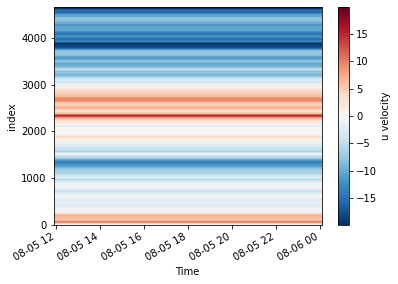

In [62]:
a.plot(x='Time', y='index')

# plt.ylabel('Height agl (m)')
# plt.title('WRF temperature advection')

plt.show()

In [ ]:
new_ds[]

SyntaxError: invalid syntax (<ipython-input-33-1de1dc17e2ea>, line 2)

In [28]:
new_ds = new_ds.rename({'index': 'Height'})

In [32]:
new_ds

<xarray.Dataset>
Dimensions:                (index: 4669)
Coordinates:
  * index                  (index) int64 0 1 2 3 4 ... 4664 4665 4666 4667 4668
Data variables:
    height agl             (index) float64 8.2 13.0 20.5 ... 2.633e+04 2.634e+04
    potential temperature  (index) float64 297.3 297.8 298.1 ... 672.6 672.7
    vapor mixing ratio     (index) float64 13.36 13.36 13.3 ... 0.024 0.024
    u velocity             (index) float64 -0.265 -0.072 0.0 ... -18.2 -18.1
    v velocity             (index) float64 3.791 4.099 4.4 ... -0.318 -0.316
    u_tend_lasso           (index) float64 -2.305e-05 -6.261e-06 ... -0.001574
    v_tend_lasso           (index) float64 -0.0003297 -0.0003565 ... 2.748e-05

In [16]:
lasso_uv_ds = lasso_plot_df.to_xarray()

In [17]:
lasso_uv_ds

<xarray.Dataset>
Dimensions:  (index: 73)
Coordinates:
  * index    (index) datetime64[ns] 2018-08-05T12:00:00 ... 2018-08-06
Data variables:
    8.2      (index) float64 -0.0003297 -0.0003297 ... -0.0003297 -0.0003297
    13.0     (index) float64 -0.0003565 -0.0003565 ... -0.0003565 -0.0003565
    20.5     (index) float64 -0.0003826 -0.0003826 ... -0.0003826 -0.0003826
    26.3     (index) float64 -0.0004087 -0.0004087 ... -0.0004087 -0.0004087
    29.8     (index) float64 -0.0004434 -0.0004434 ... -0.0004434 -0.0004434
    34.0     (index) float64 -0.0004782 -0.0004782 ... -0.0004782 -0.0004782
    40.1     (index) float64 -0.000504 -0.000504 ... -0.000504 -0.000504
    45.4     (index) float64 -0.0005388 -0.0005388 ... -0.0005388 -0.0005388
    53.6     (index) float64 -0.0005645 -0.0005645 ... -0.0005645 -0.0005645
    59.0     (index) float64 -0.0005993 -0.0005993 ... -0.0005993 -0.0005993
    63.3     (index) float64 -0.0006246 -0.0006246 ... -0.0006246 -0.0006246
    69.7     (index) float64 -0.0006507 -0.0006507 ... -0.0006507 -0.0006507
    74.7     (index) float64 -0.0006844 -0.0006844 ... -0.0006844 -0.0006844
    79.6     (index) float64 -0.0007092 -0.0007092 ... -0.0007092 -0.0007092
    86.3     (index) float64 -0.0007351 -0.0007351 ... -0.0007351 -0.0007351
    92.9     (index) float64 -0.0007595 -0.0007595 ... -0.0007595 -0.0007595
    96.9     (index) float64 -0.0007855 -0.0007855 ... -0.0007855 -0.0007855
    104.4    (index) float64 -0.0008095 -0.0008095 ... -0.0008095 -0.0008095
    109.4    (index) float64 -0.0008268 -0.0008268 ... -0.0008268 -0.0008268
    115.3    (index) float64 -0.0008503 -0.0008503 ... -0.0008503 -0.0008503
    120.4    (index) float64 -0.0008735 -0.0008735 ... -0.0008735 -0.0008735
    125.4    (index) float64 -0.0008907 -0.0008907 ... -0.0008907 -0.0008907
    131.5    (index) float64 -0.0009134 -0.0009134 ... -0.0009134 -0.0009134
    135.8    (index) float64 -0.0009272 -0.0009272 ... -0.0009272 -0.0009272
    141.3    (index) float64 -0.0009527 -0.0009527 ... -0.0009527 -0.0009527
    146.4    (index) float64 -0.000966 -0.000966 ... -0.000966 -0.000966
    152.6    (index) float64 -0.0009788 -0.0009788 ... -0.0009788 -0.0009788
    156.6    (index) float64 -0.001004 -0.001004 ... -0.001004 -0.001004
    161.2    (index) float64 -0.001016 -0.001016 ... -0.001016 -0.001016
    167.2    (index) float64 -0.001037 -0.001037 ... -0.001037 -0.001037
    171.4    (index) float64 -0.001053 -0.001053 ... -0.001053 -0.001053
    176.4    (index) float64 -0.001065 -0.001065 ... -0.001065 -0.001065
    182.1    (index) float64 -0.001083 -0.001083 ... -0.001083 -0.001083
    188.8    (index) float64 -0.0011 -0.0011 -0.0011 ... -0.0011 -0.0011 -0.0011
    193.6    (index) float64 -0.001118 -0.001118 ... -0.001118 -0.001118
    199.9    (index) float64 -0.001128 -0.001128 ... -0.001128 -0.001128
    203.7    (index) float64 -0.001145 -0.001145 ... -0.001145 -0.001145
    208.5    (index) float64 -0.001161 -0.001161 ... -0.001161 -0.001161
    213.5    (index) float64 -0.001169 -0.001169 ... -0.001169 -0.001169
    218.7    (index) float64 -0.001185 -0.001185 ... -0.001185 -0.001185
    225.6    (index) float64 -0.001201 -0.001201 ... -0.001201 -0.001201
    229.7    (index) float64 -0.001208 -0.001208 ... -0.001208 -0.001208
    235.9    (index) float64 -0.001231 -0.001231 ... -0.001231 -0.001231
    241.1    (index) float64 -0.001237 -0.001237 ... -0.001237 -0.001237
    245.2    (index) float64 -0.001243 -0.001243 ... -0.001243 -0.001243
    252.7    (index) float64 -0.001258 -0.001258 ... -0.001258 -0.001258
    258.1    (index) float64 -0.001263 -0.001263 ... -0.001263 -0.001263
    264.0    (index) float64 -0.001279 -0.001279 ... -0.001279 -0.001279
    268.4    (index) float64 -0.001282 -0.001282 ... -0.001282 -0.001282
    272.7    (index) float64 -0.001285 -0.001285 ... -0.001285 -0.001285
    277.2    (index) float64 -0.001301 -0.001301 ... -0.001301 -0.001301
    282.3    (index) float6

In [20]:
lasso_uv_ds[8.2]

<xarray.DataArray 8.2 (index: 73)>
array([-0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968, -0.00032968, -0.00032968,
       -0.00032968, -0.00032968, -0.00032968])
Coordinates:
  * index    (index) datetime64[ns] 2018-08-05T12:00:00 ... 2018-08-06

In [19]:
stacked = lasso_uv_ds.stack(z=(8.2, 13.0))

KeyError: 8.2

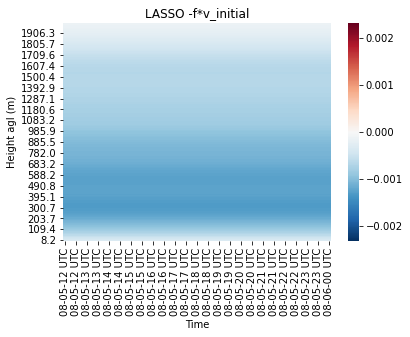

In [188]:
vm = np.max([abs(lasso_plot_df.max().max()), abs(lasso_plot_df.min().min())]) + 0.001
ax = sns.heatmap(lasso_plot_df.T, cmap='RdBu_r', vmin=-vm, vmax=vm)
ax.invert_yaxis()
ax.set_title('LASSO -f*v_initial')
ax.set_ylabel('Height agl (m)')
ax.set_xlabel('Time')
plt.show()

In [225]:
def get_lasso_ds(file, year, month, date):

    ds = xr.open_dataset(file)

    for ind, val in enumerate(ds['Times']): 

        ds.Times.values[ind] = ds.Times.values[ind].decode("utf-8")
        ds.Times.values[ind] = datetime.datetime.strptime(ds.Times.values[ind], '%Y-%m-%d_%H:%M:%S')
    #     ds.Times.values[ind] = np.datetime64(ds.Times.values[ind])

    ds = ds.assign_coords({'Time': ds.Times})

    # select 24 hours of data
    select = ds.sel(Time=slice(datetime.datetime(year, month, date), datetime.datetime(year, month, date+1)))

    # subset = select.where(select.Z_LS == target_height_agl, drop=True)
    
#     hgt = 
    select = select.assign_coords({'force_layers': select['Z_LS'][0].values})
    
    return select

lasso_forcing = '/projects/mmcpnnl/jlee/lasso/0805/0805-3/config/input_ls_forcing.nc'

lasso_ds = get_lasso_ds(lasso_forcing, 2018, 8, 5)

In [226]:
lasso_ds

<xarray.Dataset>
Dimensions:       (Time: 25, force_layers: 751)
Coordinates:
  * Time          (Time) object 2018-08-05T12:00:00 ... 2018-08-06
  * force_layers  (force_layers) float32 0.0 20.0 40.0 ... 1.498e+04 1.5e+04
Data variables:
    Times         (Time) object 2018-08-05T12:00:00 ... 2018-08-06
    Z_LS          (Time, force_layers) float32 ...
    U_LS          (Time, force_layers) float32 ...
    V_LS          (Time, force_layers) float32 ...
    W_LS          (Time, force_layers) float32 ...
    TH_ADV        (Time, force_layers) float32 ...
    TH_RLX        (Time, force_layers) float32 ...
    QV_ADV        (Time, force_layers) float32 ...
    QV_RLX        (Time, force_layers) float32 ...
    Z_LS_TEND     (Time, force_layers) float32 ...
    W_LS_TEND     (Time, force_layers) float32 ...
    U_LS_TEND     (Time, force_layers) float32 ...
    V_LS_TEND     (Time, force_layers) float32 ...
    TH_ADV_TEND   (Time, force_layers) float32 ...
    TH_RLX_TEND   (Time, force_layers) float32 ...
    QV_ADV_TEND   (Time, force_layers) float32 ...
    QV_RLX_TEND   (Time, force_layers) float32 ...
    INV_TAU_S     (Time, force_layers) float32 ...
    INV_TAU_M     (Time, force_layers) float32 ...
    P_SFC_OPT     (Time) float32 ...
Attributes:
    TITLE:    AUXILIARY FORCING FOR CRM/LES/SCM
    SOURCE:   ecmwf/sgpecmwffrc_mddhmassfix_d20.20180805.nc

In [227]:
lassods_below2km = lasso_ds.where(lasso_ds['force_layers'] < 2000, drop=True)

In [228]:
lassods_below2km['TH_ADV_TEND']

<xarray.DataArray 'TH_ADV_TEND' (Time: 25, force_layers: 100)>
array([[-9.01118291e-09, -7.74238362e-09, -5.95037530e-09, ...,
        -2.02526795e-09, -1.83559068e-09, -1.64591252e-09],
       [-8.86436347e-09, -9.69243263e-09, -9.64737712e-09, ...,
         1.31136502e-09,  1.36008460e-09,  1.40880430e-09],
       [-8.86436347e-09, -9.69243263e-09, -9.64737801e-09, ...,
         1.31136602e-09,  1.36008460e-09,  1.40880430e-09],
       ...,
       [ 1.13417142e-08,  1.30745503e-08,  1.59765463e-08, ...,
        -1.18670584e-08, -8.08680234e-09, -4.30655023e-09],
       [ 9.57375690e-09,  9.45504031e-09,  9.18591159e-09, ...,
        -1.85298301e-08, -2.26024515e-08, -2.66750710e-08],
       [ 9.57375690e-09,  9.45504031e-09,  9.18591159e-09, ...,
        -1.85298354e-08, -2.26024550e-08, -2.66750746e-08]], dtype=float32)
Coordinates:
  * Time          (Time) object 2018-08-05T12:00:00 ... 2018-08-06
  * force_layers  (force_layers) float32 0.0 20.0 40.0 ... 1.96e+03 1.98e+03
Attributes:
    FieldType:    104
    MemoryOrder:  Z  
    description:  time tendency of TH_ADV
    units:        K s-2
    stagger:

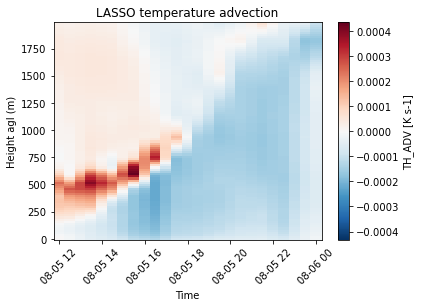

In [239]:
lassods_below2km['TH_ADV'].plot(x='Time', y='force_layers')

#plt.xticklabels(rotation=45)
plt.tick_params(axis='x', rotation=45)
plt.ylabel('Height agl (m)')
plt.title('LASSO temperature advection')

plt.show()

In [158]:
wrf_columns = ['t_tend', 'u_tend', 'v_tend']
lasso_columns = ['TH_ADV', 'U_LS_TEND', 'V_LS_TEND']
plot_txt = ['thermal advection (K $s^{-1}$)', 'zonal wind velocity (m $s^{-2}$)', 
            'meridional wind velocity (m $s^{-2}$)']
meta_df = pd.DataFrame(data=[wrf_columns, lasso_columns, plot_txt], columns=['t', 'u', 'v'], 
                       index=['wrf', 'lasso', 'p_txt'])

def get_wrf_area_avg_tend(dpath):

    df = pd.DataFrame(columns=wrf_columns)

    for file in glob.glob(dpath+'mmc_d02*'):

        wrf_single = Dataset(file,'r')

        site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)
        area_start_ind = site_loc_ij.values-wrf_ij_diff
        area_end_ind = site_loc_ij.values+wrf_ij_diff

        wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)
        # height should not change over time in wrf
        z_agl  = wrf.getvar(wrf_single, 'height_agl')
        
        t_tend_adv = wrf.getvar(wrf_single, 'T_TEND_ADV', timeidx=wrf.ALL_TIMES)
        mut = wrf.getvar(wrf_single, 'MUT', timeidx=wrf.ALL_TIMES)

        ru_tend = wrf.getvar(wrf_single, 'RU_TEND_PGF', timeidx=wrf.ALL_TIMES)
        muu = wrf.getvar(wrf_single, 'MUU', timeidx=wrf.ALL_TIMES)
        
        rv_tend = wrf.getvar(wrf_single, 'RV_TEND_PGF', timeidx=wrf.ALL_TIMES)
        muv = wrf.getvar(wrf_single, 'MUV', timeidx=wrf.ALL_TIMES)

        # to match lasso data
        t_tend = t_tend_adv/mut
        u_tend = ru_tend/muu
        v_tend = rv_tend/muv

        levels = np.asarray([target_height_agl])

        df_1file = pd.DataFrame(index=wrf_time, columns=wrf_columns)

        for t_ind, t in enumerate(wrf_time): 

            t_tend_list, u_tend_list, v_tend_list = [], [], []

            for i in range(int(area_start_ind[0]), int(area_end_ind[0]+1)):
                for j in range(int(area_start_ind[1]), int(area_end_ind[1]+1)): 
                    
                    if wrf_time.shape[0] > 1: 
                        t_tend_1pt = t_tend[t_ind, :, i, j]
                        u_tend_1pt = u_tend[t_ind, :, i, j]
                        v_tend_1pt = v_tend[t_ind, :, i, j]
                    # for wrfout files that contain 1 time
                    # e.g. the last out file of a run
                    else: 
                        t_tend_1pt = t_tend[:, i, j]
                        u_tend_1pt = u_tend[:, i, j]
                        v_tend_1pt = v_tend[:, i, j]
                    
                    z_agl_1pt = z_agl[:, i, j]

                    # tried wrf.vinterp(), can't get it working
                    t_tend_itp = wrf.interp1d(t_tend_1pt, z_agl_1pt, levels)
                    u_tend_itp = wrf.interp1d(u_tend_1pt, z_agl_1pt, levels)
                    v_tend_itp = wrf.interp1d(v_tend_1pt, z_agl_1pt, levels)

                    t_tend_list.append(t_tend_itp.values[0])
                    u_tend_list.append(u_tend_itp.values[0])
                    v_tend_list.append(v_tend_itp.values[0])

            df_1file.loc[t, [meta_df['t']['wrf']]] = np.mean(t_tend_list)
            df_1file.loc[t, [meta_df['u']['wrf']]] = np.mean(u_tend_list)
            df_1file.loc[t, [meta_df['v']['wrf']]] = np.mean(v_tend_list)

        df = df.append(df_1file)

    df.sort_index(inplace=True)
    
    return df

def get_lasso_df_1height(file, year, month, date):

    ds = xr.open_dataset(file)

    for ind, val in enumerate(ds['Times']): 

        ds.Times.values[ind] = ds.Times.values[ind].decode("utf-8")
        ds.Times.values[ind] = datetime.datetime.strptime(ds.Times.values[ind], '%Y-%m-%d_%H:%M:%S')
    #     ds.Times.values[ind] = np.datetime64(ds.Times.values[ind])

    ds = ds.assign_coords({'Time': ds.Times})

    # select 24 hours of data
    select = ds.sel(Time=slice(datetime.datetime(year, month, date), datetime.datetime(year, month, date+1)))

    subset = select.where(select.Z_LS == target_height_agl, drop=True)
    
    return subset

def plot_tend_2ts(wrf_df, lasso_df, var, sim_day_txt): 
    
    plt.plot(wrf_df.index, wrf_df[meta_df[var]['wrf']], label='WRF')
    plt.plot(lasso_df['Time'], lasso_df[meta_df[var]['lasso']], label='LASSO')

    if sim_day_txt[-1] == 'e':
        add_txt = 'dmf'
    elif sim_day_txt[-1] == 'm':
        add_txt = 'ynn'
    
    plt.title(sim_day_txt+add_txt+' '+meta_df[var]['p_txt']+' at '+str(target_height_agl)+' m')
    plt.xlabel('UTC time')
    plt.ylabel(r''+meta_df[var]['p_txt'])
    plt.legend()
    
    plt.savefig('plots_02a/tend_ts_'+sim_day_txt+'_'+var+'.pdf')
    
    plt.show()

## 0805 mynn

In [23]:
wrf_path = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805m/auxout/target/'
wrf_df = get_wrf_area_avg_tend(wrf_path)

lasso_file = '/projects/mmcpnnl/jlee/lasso/0805/0805-3/config/input_sounding'

lasso_input_sounding_col = ['height agl', 'potential temperature', 'vapor mixing ratio', 
                            'u velocity', 'v velocity']

df = pd.read_csv(lasso_file, skiprows=1, sep=' ')

new_df = (df.T.reset_index().T.reset_index(drop=True)
            .set_axis([i for i in lasso_input_sounding_col], axis=1))

for col in new_df.columns:
    new_df[col] = pd.to_numeric(new_df[col])

# new_df.head(20)

bottom = new_df.loc[new_df['height agl'] < target_height_agl].iloc[-1]
top = new_df.loc[new_df['height agl'] > target_height_agl].iloc[0]

u_target = bottom['u velocity'] + (target_height_agl-bottom['height agl']) \
    * ((top['u velocity']-bottom['u velocity']) / (top['height agl']-bottom['height agl']))

f = 2 * 7.292*1e-5 * math.sin(math.radians(site_latitude))

u_tend_lasso = f*u_target

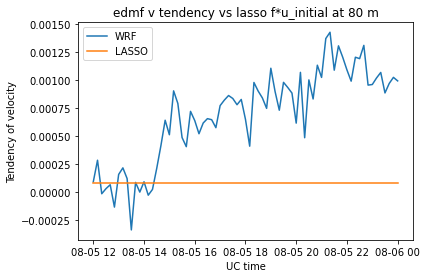

In [26]:
plt.plot(wrf_df.index, wrf_df[meta_df['v']['wrf']], label='WRF')
# plt.plot(lasso_df['Time'], lasso_df[meta_df[var]['lasso']], label='LASSO')
u_tend_lasso_s = np.tile(u_tend_lasso, reps=wrf_df.index.shape)
plt.plot(wrf_df.index, u_tend_lasso_s, label='LASSO')

# if sim_day_txt[-1] == 'e':
#     add_txt = 'dmf'
# elif sim_day_txt[-1] == 'm':
#     add_txt = 'ynn'
add_txt = 'dmf'

plt.title('edmf v tendency vs lasso f*u_initial at 80 m')
plt.xlabel('UC time')
plt.ylabel('Tendency of velocity')
plt.legend()

# plt.savefig('plots_02a/tend_ts_'+sim_day_txt+'_'+var+'.pdf')

plt.show()

In [17]:
u_tend_lasso_s = np.tile(u_tend_lasso, reps=wrf_df.index.shape)

array([7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
       7.46887981e-05, 7.46887981e-05, 7.46887981e-05, 7.46887981e-05,
      

In [15]:
wrf_df.index.shape

(73,)

In [60]:
f = 2 * 7.292*1e-5 * math.sin(math.radians(site_latitude))

In [68]:
f * u_target

7.468879814369826e-05

In [28]:
new_df['potential temperature'].values

array([297.34, 297.82, 298.1 , ..., 672.5 , 672.59, 672.74])

In [41]:
new_df.loc[new_df['height agl'] < target_height_agl]['u velocity'].iloc[-1]

0.857

In [39]:
new_df.loc[new_df['height agl'] > target_height_agl]['u velocity'].iloc[0]

0.888

In [36]:
target_height_agl - 

int

In [51]:
bottom = new_df.loc[new_df['height agl'] < target_height_agl].iloc[-1]
top = new_df.loc[new_df['height agl'] > target_height_agl].iloc[0]

u_target = bottom['u velocity'] + (target_height_agl-bottom['height agl']) * ((top['u velocity']-bottom['u velocity']) / (top['height agl']-bottom['height agl']))

In [52]:
u_target

0.8588507462686568

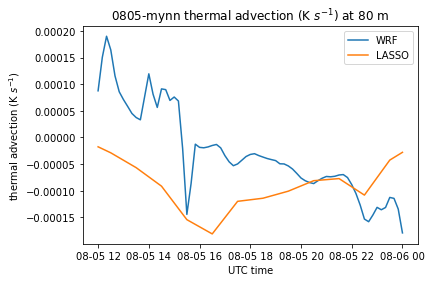

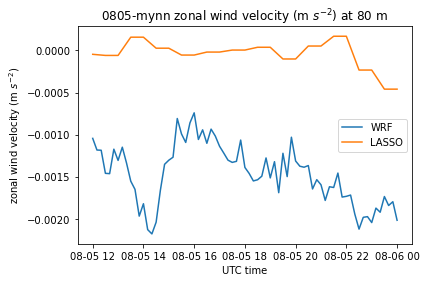

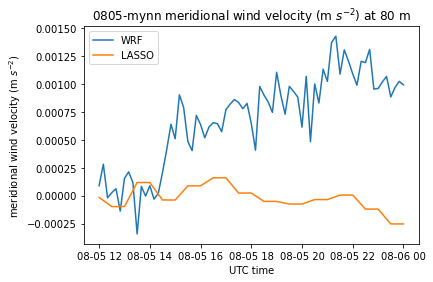

In [159]:
lasso_file = '/projects/mmcpnnl/jlee/lasso/0805/0805-3/config/input_ls_forcing.nc'
wrf_path = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805m/auxout/target/'

sim_day_txt = '0805-m'
lasso_df = get_lasso_df_1height(lasso_file, 2018, 8, 5)

wrf_df = get_wrf_area_avg_tend(wrf_path)

plot_tend_2ts(wrf_df, lasso_df, 't', sim_day_txt)
plot_tend_2ts(wrf_df, lasso_df, 'u', sim_day_txt)
plot_tend_2ts(wrf_df, lasso_df, 'v', sim_day_txt)

## 0805 edmf

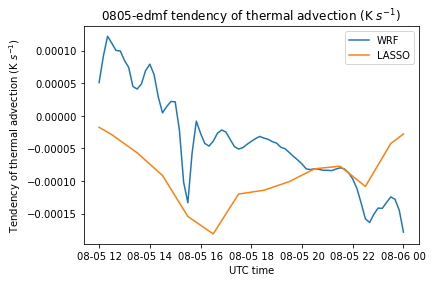

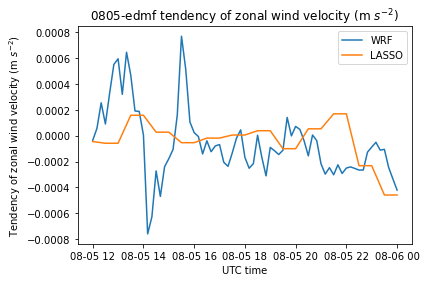

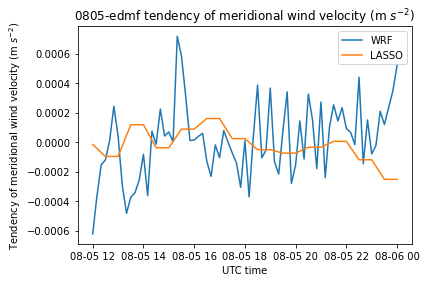

In [4]:
lasso_file = '/projects/mmcpnnl/jlee/lasso/0805-3/config/input_ls_forcing.nc'
wrf_path = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0805e/auxout/target/'

sim_day_txt = '0805-e'
lasso_df = get_lasso_df_1height(lasso_file, 2018, 8, 5)

wrf_df = get_wrf_area_avg_tend(wrf_path)

plot_tend_2ts(wrf_df, lasso_df, 't', sim_day_txt)
plot_tend_2ts(wrf_df, lasso_df, 'u', sim_day_txt)
plot_tend_2ts(wrf_df, lasso_df, 'v', sim_day_txt)

## 0901 mynn

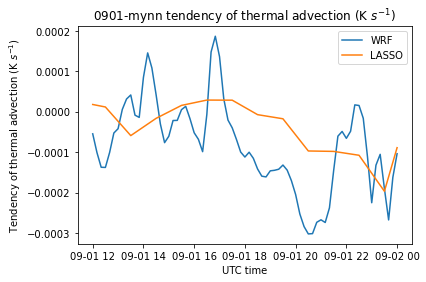

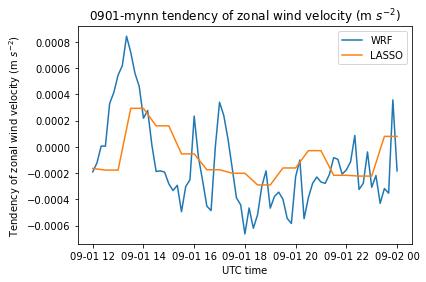

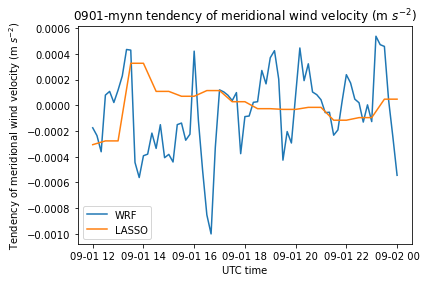

In [5]:
lasso_file = '/projects/mmcpnnl/jlee/lasso/0901-3/config/input_ls_forcing.nc'
wrf_path = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0901m/auxout/target/'

sim_day_txt = '0901-m'
lasso_df = get_lasso_df_1height(lasso_file, 2018, 9, 1)

wrf_df = get_wrf_area_avg_tend(wrf_path)

plot_tend_2ts(wrf_df, lasso_df, 't', sim_day_txt)
plot_tend_2ts(wrf_df, lasso_df, 'u', sim_day_txt)
plot_tend_2ts(wrf_df, lasso_df, 'v', sim_day_txt)

## 0901 edmf

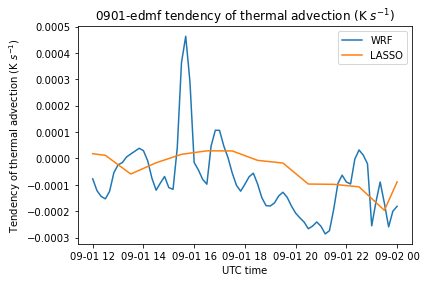

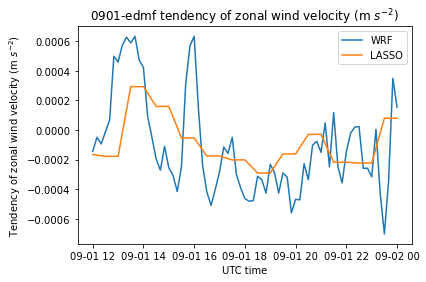

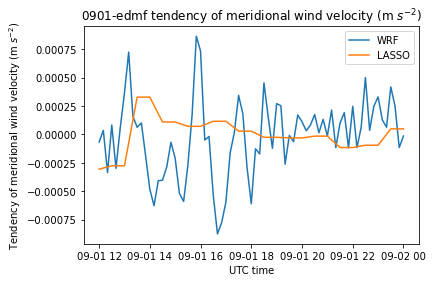

In [6]:
lasso_file = '/projects/mmcpnnl/jlee/lasso/0901-3/config/input_ls_forcing.nc'
wrf_path = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/0901e/auxout/target/'

sim_day_txt = '0901-e'
lasso_df = get_lasso_df_1height(lasso_file, 2018, 9, 1)

wrf_df = get_wrf_area_avg_tend(wrf_path)

plot_tend_2ts(wrf_df, lasso_df, 't', sim_day_txt)
plot_tend_2ts(wrf_df, lasso_df, 'u', sim_day_txt)
plot_tend_2ts(wrf_df, lasso_df, 'v', sim_day_txt)